# Simulating Systems of Springs in 2 Dimensions

This notebook will cover the method for which systems of springs can be simulated.

In [1]:
#type of display for the text section
from IPython.display import display, Math, Latex

#import libraries
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "html5"
from scipy.integrate import odeint

#magic codes
%matplotlib notebook


Here is an example system:

$X=\begin{bmatrix} x_{1x} & x_{1y} \\ x_{2x} & x_{2y} \\ x_{3x} & x_{3y} \end{bmatrix}$
$,\ M=\begin{bmatrix} m_1 \\ m_2 \\ m_3 \end{bmatrix}$

$K=\begin{bmatrix} 0 & k & k \\ k & 0 & k \\ k & k & 0\end{bmatrix}$
$,\ L=\begin{bmatrix} 0 & l_{12} & l_{13} \\ l_{21} & 0 & l_{23} \\ l_{31} & l_{32} & 0\end{bmatrix}$

$D=\begin{bmatrix} 0 & d_{12} & d_{13} \\ d_{21} & 0 & d_{23} \\ d_{31} & d_{32} & 0 \end{bmatrix}$
$,\ d_{xy}=\frac{||\mathbf{x_x}-\mathbf{x_y}||-l_{xy}}{||\mathbf{x_x}-\mathbf{x_y}||}$

$\Delta D=\begin{bmatrix} 0 & \mathbf{x_1}-\mathbf{x_2} & \mathbf{x_1}-\mathbf{x_3} \\ \mathbf{x_2}-\mathbf{x_1} & 0 & \mathbf{x_2}-\mathbf{x_3} \\ \mathbf{x_3}-\mathbf{x_1} & \mathbf{x_3}-\mathbf{x_2} & 0\end{bmatrix}$

Using this information it should be simple to calculate the forces and then from there calculate the position, velocity and acceleration of each mass in the system.

Below is an example graph of a system described by the equations above.

Implementing the equations above in code is a little trickly becuase scipy only has an Eulers method that works on 1Xn vectors or nXm matricies. This limits the implementation below to just vectors and matricies.

Possibly a matrix like this could work:

$X_{xv}=\begin{bmatrix} x_{1x} & x_{1y} & v_{1x} & v_{1y} \\ x_{2x} & x_{2y} & v_{2x} & v_{2y} \\ x_{3x} & x_{3y} & v_{3x} & v_{3y} \end{bmatrix}$

In [3]:
def calculateDiffsBetweenMasses(X_xv):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    D_L = np.zeros(shape=(rows, columns*rows)) #left distance matrix
    D_R = np.zeros(shape=(rows, columns*rows)) #right distance matrix
    
    for i in range(0, rows):
        for j in range(0, rows):
            D_L[i,d*j:d*j+d] = X_xv[i,0:d]
            D_R[j,d*i:d*i+d] = X_xv[i,0:d]
            
    Delta_D = D_R-D_L
    return Delta_D

In [4]:
def calculateMagnitudesBetweenMasses(X_xv, L):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    D = np.zeros(shape=(rows, rows)) #square matrix of values
    
    for row_index in range(0, rows):
        for column_index in range(0, rows):
            if (row_index==column_index):
                continue
            diff = X_xv[row_index,0:d]-X_xv[column_index,0:d]
            mag = np.sqrt(np.dot(diff,diff))
            D[row_index, column_index] = (mag-L[row_index, column_index])/mag
    return D

In [5]:
def calculateDifferences(X_xv, Delta_D, D, M, K, F):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    deltas = X_xv.copy()
    
    for row_index in range(0, rows): #calculate for each mass
        if (F[row_index] == 1):
            deltas[row_index] = np.zeros(d*2)
            continue
        deltas[row_index,0:d] = deltas[row_index,d:2*d]
        deltas[row_index,d:2*d] = np.zeros(d)
        
        for sum_index in range(0, rows):
            #if (row_index==sum_index):
            #    continue
            if (K[row_index, sum_index]!=0.0): #then add to sum
                
                #VERY IMPORTAMT, the sign of Delta_D MUST be right
                deltas[row_index,d:2*d] = deltas[row_index,d:2*d] + D[row_index,
                    sum_index]*Delta_D[row_index,d*sum_index:d*sum_index+d]*K[row_index, sum_index]
            else: #the mass is not connected to this one
                continue
        deltas[row_index, d:2*d] = (deltas[row_index, d:2*d])/M[row_index] #- (0.95)*deltas[row_index,d:2*d])/M[row_index]
    return deltas

In [6]:
def SpringSystem(X_xv, t, M, K, L, F, shape_working, shape_end):
    X_xv = X_xv.reshape(shape_working)
    Delta_D = calculateDiffsBetweenMasses(X_xv)
    D = calculateMagnitudesBetweenMasses(X_xv, L)
    X_xv = calculateDifferences(X_xv, Delta_D, D, M, K, F)
    X_xv = X_xv.reshape(shape_end)
    return X_xv

Here is an interesting test case that produces a ribbon type plot in 3 dimensions.

In [27]:
plt.close()
X0 = np.zeros(shape=(5,6))
X0[0] = [0,0,0,0,0,0]
X0[1] = [1,0,0,0,0,0]
X0[2] = [1,1,0,0,0,0]
X0[3] = [0,1,0,0,0,0]
X0[4] = [1,1.1,1,0,0,0] #[1,0.25,1,0,0,0]

M = np.ones(shape=(5,1))
F = np.ones(shape=(5,1))
F[4] = [0]

K = np.ones(shape=(5,5))
K[0] = [0,1,0,1,1]
K[1] = [1,0,1,0,1]
K[2] = [0,1,0,1,1]
K[3] = [1,0,1,0,1]
K[4] = [1,1,1,1,0]

s2 = np.sqrt(5/4.) #np.sqrt(3/2.)
L = np.ones(shape=(5,5))
L[0] = [0,1,0,1,1]
L[1] = [1,0,1,0,1]
L[2] = [0,1,0,1,1]
L[3] = [1,0,1,0,1]
L[4] = [s2,s2,s2,s2,0]

rez = 10000
end = 210.0
refresh = int(1000/(rez/end))
t = np.linspace(0, end, rez)

shape_working = X0.shape
shape_end = (X0.shape[0]*X0.shape[1],)
X0 = X0.reshape(shape_end)
sol = odeint(SpringSystem, X0, t, args=(M, K, L , F, shape_working, shape_end))
print (sol[1])

[ 0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.          1.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.         -0.54024901  0.63403124  0.24610011
 -0.49687187 -0.55757501  0.58387276]
[ 0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.          1.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.99987047  1.09984647  0.99984061
 -0.01233396 -0.0146188  -0.01517628]


Now plot the above solution curve for the above system.

<IPython.core.display.Javascript object>


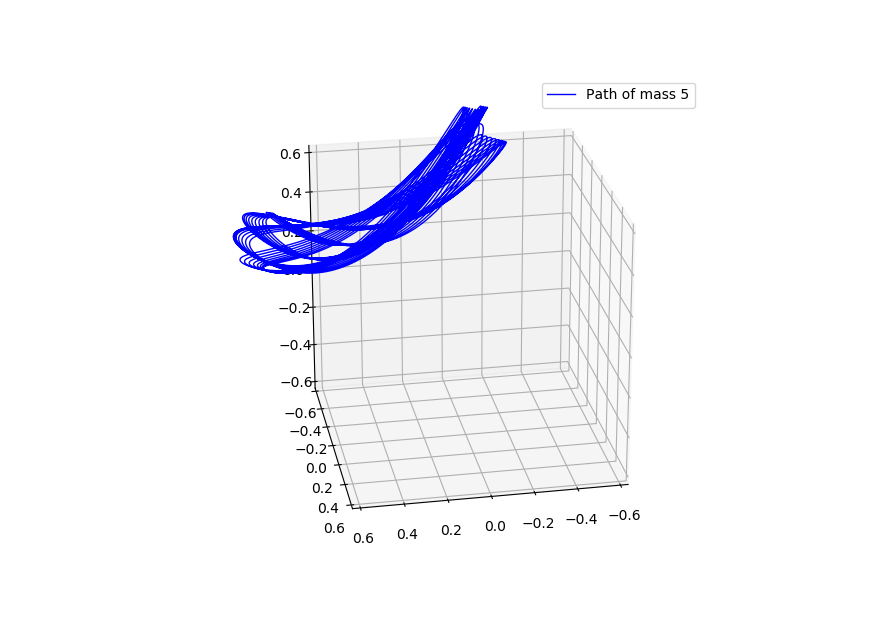

In [28]:
#plt.title('Position for two springs')
#plt.plot(sol[:,24:25], sol[:,25:26], label='x_5')
#plt.legend()
#plt.grid()
#plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')
ax.set_zlim3d(-1, 1)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
#plot out data to the screen
ax.plot(sol[:,24:25].reshape(len(sol)),sol[:,25:26].reshape(len(sol))
        ,sol[:,26:27].reshape(len(sol)), 'b-' ,label='Path of mass 5',markersize=1, linewidth=1)
ax.legend()
plt.show()

And here is the physical perspective.

<IPython.core.display.Javascript object>


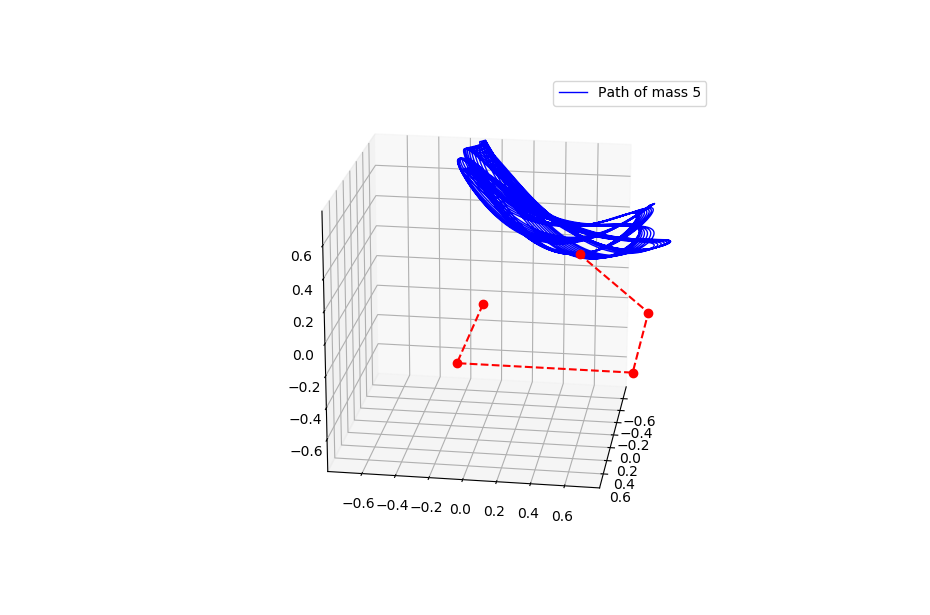

In [29]:
plt.close()
fig3d = plt.figure()
ax = fig3d.gca(projection='3d')
ax.set_aspect('equal')
ax.set_zlim3d(-1, 1)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.plot(sol[:,24:25].reshape(len(sol)),sol[:,25:26].reshape(len(sol))
        ,sol[:,26:27].reshape(len(sol)), 'b-' ,label='Path of mass 5',markersize=1, linewidth=1)
xs = [sol[0,0:3][0],sol[0,6:9][0],sol[0,12:15][0], sol[0,18:21][0], sol[0,24:27][0]]
ys = [sol[0,0:3][1],sol[0,6:9][1],sol[0,12:15][1], sol[0,18:21][1], sol[0,24:27][1]]
zs = [sol[0,0:3][2],sol[0,6:9][2],sol[0,12:15][2], sol[0,18:21][2], sol[0,24:27][2]]
masses, = ax.plot(xs, ys, zs, 'r--o')


def animate(x_i):
    print (x_i)
    xs = [x_i[0],x_i[6],x_i[12], x_i[18], x_i[24]]
    ys = [x_i[1],x_i[7],x_i[13], x_i[19], x_i[25]]
    zs = [x_i[2],x_i[8],x_i[14], x_i[20], x_i[26]]
    masses.set_data(xs, ys)  # update the data
    masses.set_3d_properties(zs)
    return masses,


# Init only required for blitting to give a clean slate.
def init():
    #line.set_ydata(np.ma.array(x, mask=True))
    return masses,

refresh=5
ani = animation.FuncAnimation(fig3d, animate, sol, init_func=init,
                              interval=refresh, blit=True)

plt.legend()
plt.grid()
plt.show()